<table>
    <tr><td><h2>A pythonic approach to BigQuery data manipulation</h2></td>
    <td><img src="https://koalas.readthedocs.io/en/latest/_static/koalas-logo-docs.png"></img></td></tr>
</table>

<b>Problem:</b> BigQuery is the best place to run SQL.  Still, I often find myself limited by SQL's functionality. I normally work with a combination of Pandas and SQL but Pandas won't work with the size of BigQuery's tables. 

SQL can be verbose and hard to maintain for transformations.  For SQL analysis, the focus is really on reporting. I feel that SQL still lacks a lot of what is necessity for me to perform advanced statistics, ML, and timeseries analysis.  

I wish there was a way to bring the advanced Pandas capablities I have on my laptop to BigQuery scale tables.

In [ ]:
conda install -c conda-forge koalas

<h4>Create a Spark Session with the BigQuery connector loaded</h4>

In [4]:
# %load sparkme
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
scala_minor_version = str(spark.sparkContext._jvm.scala.util.Properties.versionString().replace("version ","").split('.')[1])
spark = SparkSession.builder.config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2." + scala_minor_version + ":0.18.0") \
                                    .enableHiveSupport() \
                                    .getOrCreate()

<img src="https://miro.medium.com/max/1816/1*CpGwN0yO8IMER-tcfasEeA.png" height=450 width=450></img>

In [5]:
df = spark.read \
  .format("bigquery") \
  .load("bigquery-public-data.covid19_nyt.us_counties")

In [6]:
df.show(5)

+----------+-----------+----------+----------------+---------------+------+
|      date|     county|state_name|county_fips_code|confirmed_cases|deaths|
+----------+-----------+----------+----------------+---------------+------+
|2020-10-04|     Joplin|  Missouri|            null|           2040|    25|
|2020-10-04|Kansas City|  Missouri|            null|          11387|   106|
|2020-10-05|     Joplin|  Missouri|            null|           2046|    25|
|2020-10-05|Kansas City|  Missouri|            null|          11387|   106|
|2020-10-06|     Joplin|  Missouri|            null|           2059|    25|
+----------+-----------+----------+----------------+---------------+------+
only showing top 5 rows



<h3>All Spark Dataframe functionality is available in df. But let's use the Pandas API with Kolas. A Spark version of Pandas.</h3>

In [7]:
import databricks.koalas as ks
dfq = df.to_koalas()

In [8]:
dfq.describe()

,confirmed_cases,deaths
count,884817.000000,866056.000000
mean,1952.157425,53.591608
std,10106.149522,451.836007
min,0.000000,0.000000
25%,36.000000,0.000000
50%,228.000000,4.000000
75%,993.000000,21.000000
max,770915.000000,25144.000000


Often (especially for ML+Stats), we want to transpose columns. In SQL, this can be a long chain of 

CASE WHEN county = 'Joplin' AND state = 'Missouri' THEN sum(confirmed_cases) AS JOPIN_CONFIRMED_CASES<br>
CASE WHEN county = 'Joplin' AND state = 'Missouri' THEN sum(deaths) AS JOPIN_DEATHS

Which needs to be repeated for every county in the United States -- for this dataset, that would be over 800K rows of SQL
Using Kolas, this is done with a one line Transpose(T) function.

In [9]:
with ks.option_context('compute.max_rows', 1000000): 
    transformed = dfq.groupby(['state_name','county']).sum().sort_index().T

In [10]:
transformed.head()

state_name        Alabama                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Alaska                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Arizona                                                                                                                                                           Arkansas                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 California                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Colorado                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Connecticut                                                                                     Delaware                                District of Columbia    Florida                                                                                                                                                                                                                                                                                                                                                                  

Creating dummy variables for categorical datasets is another popular ML/stats preperation step that can be difficult in SQL but a single function in Kolas

In [14]:
dummies = ks.get_dummies(dfq)

In [ ]:
dummies

Additional data manipulation techniques (ex. time series functionality) and quick access to plots are also some of the many helpful features of using Python at BQ scale

<AxesSubplot:xlabel='state_name'>

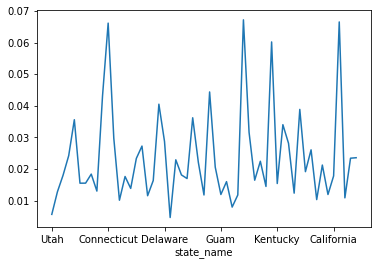

In [86]:
state_grouped = dfq.groupby('state_name').sum() 
state_death_rate = state_grouped['deaths'] / state_grouped['confirmed_cases']
state_death_rate.plot()